# Inverted pendulum
Reference: Steven L. Brunton, J. Nathan Kutz, Data Driven Science & Engineering: Machine Learning, Dynamical Systems, and Control

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Nonlinear system without control

In [2]:
# time iteration
def pendulum(time, dt, m, l, g, a, x):
    angle = [x[0]]
    N = np.array([[0.],[0.]]) # dummy

    for t in time[1:]:
        N[0] = x[1]
        N[1] = (-a*x[1]+l*g*m*np.sin(x[0]))/(m*l**2) # u=0
        x = x + dt*N
        angle.append(x[0])
    return angle

In [13]:
m = 1 # mass of the pendulum
l = 0.3 # length of the pendulum
g = 9.8 # gravity
a = 0.25 # coefficient of rotational friction

In [14]:
# time
t_end = 50
dt = 0.01
time = np.linspace(0, t_end, int(5/dt)+1)

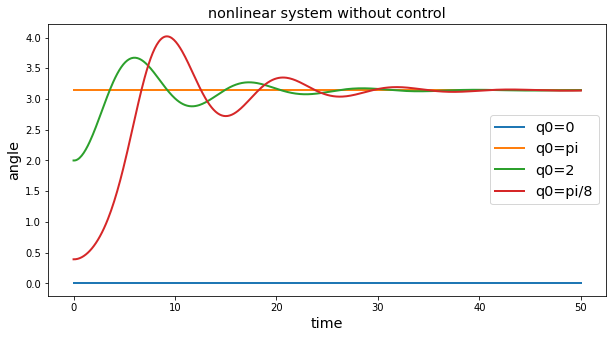

In [27]:
# state vectors
x0 = np.array([[0.],[0.]]) #initial q = 0. dq = 0
x1 = np.array([[np.pi],[0.]]) #initial q = pi dq = 0
x2 = np.array([[2.],[0.]]) #initial q = 1 dq = 0
x3 = np.array([[np.pi/8],[0.]]) #initial q = -1 dq = 0

# plot
plt.figure(figsize=(10,5))
plt.plot(time, pendulum(time, dt, m, l, g, a, x0), linewidth=2)
plt.plot(time, pendulum(time, dt, m, l, g, a, x1), linewidth=2)
plt.plot(time, pendulum(time, dt, m, l, g, a, x2), linewidth=2)
plt.plot(time, pendulum(time, dt, m, l, g, a, x3), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('nonlinear system without control', fontsize="x-large")
plt.show()

## 2. Linearization

In [28]:
# x dot = Ax + Bu drived from the taylor expension of the equation at x=0
A = np.array([[0,1],[g/l,-a/(l**2*m)]])
B = np.array([[0],[1/(l*m)]])

### 2.1 Open loop linear system

In [29]:
# linearization
# open loop
def open_loop_pendulum(time, dt, A, x):
    angle = [x[0]]

    for t in time[1:]:
        x = x + dt*A @ x 
        angle.append(x[0])
    return angle

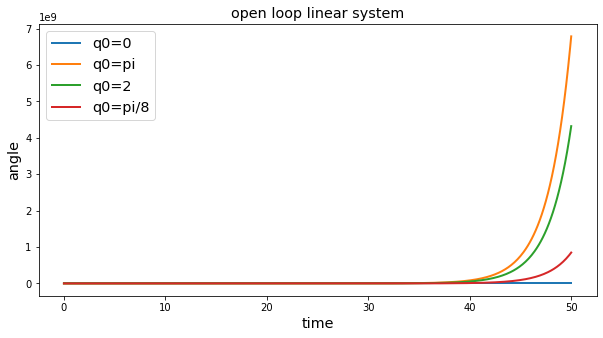

In [31]:
# plot
plt.figure(figsize=(10,5))
plt.plot(time, open_loop_pendulum(time, dt, A, x0), linewidth=2)
plt.plot(time, open_loop_pendulum(time, dt, A, x1), linewidth=2)
plt.plot(time, open_loop_pendulum(time, dt, A, x2), linewidth=2)
plt.plot(time, open_loop_pendulum(time, dt, A, x3), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('open loop linear system', fontsize="x-large")
plt.show()

### 2.2 Closed loop linear system with unstability

In [32]:
# linearization
# closed loop
def closed_loop_pendulum(time, dt, A, B, K, x):
    P = A - B @ K
    angle = [x[0]]

    for t in time[1:]:
        x = x + dt*(P @ x)
        angle.append(x[0])
    return angle

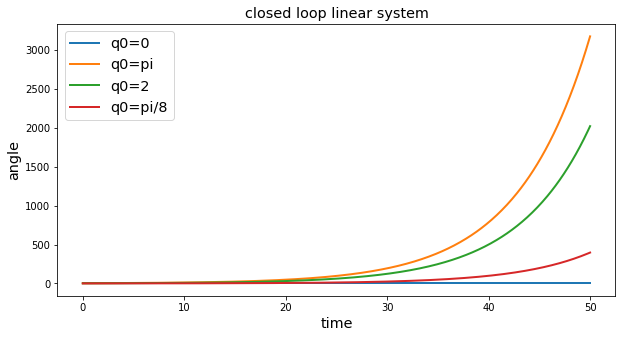

In [33]:
# 1. control gain u=-Kx (unstable)
K = np.array([[1, 5]]) # 1x2

plt.figure(figsize=(10,5))
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x0), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x1), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x2), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x3), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('closed loop linear system', fontsize="x-large")
plt.show()

### 2.3 Closed loop linear system with a suitable control gain

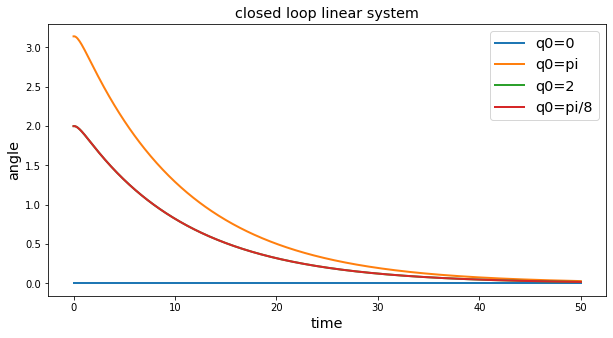

In [34]:
# 1. control gain u=-Kx (stable)
K = np.array([[15, 5]]) # 1x2

plt.figure(figsize=(10,5))
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x0), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x1), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x2), linewidth=2)
plt.plot(time, closed_loop_pendulum(time, dt, A, B, K, x2), linewidth=2)
plt.xlabel('time', fontsize="x-large")
plt.ylabel('angle', fontsize="x-large")
plt.legend(['q0=0','q0=pi','q0=2','q0=pi/8'], fontsize="x-large")
plt.title('closed loop linear system', fontsize="x-large")
plt.show()